In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
features = iris.data
target = iris.target

sepal_length = np.array(features[:,0])
petal_width = np.array(features[:,3])

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_names = [species_map[i] for i in target]

In [3]:
def predict(intercept, coefficient, x):
  return intercept + coefficient * x

In [4]:
def rms(past_values, current_value, momentum=0.9, eps=1e-8):
    average = momentum * np.mean(past_values**2) + (1 - momentum) * current_value**2
    return np.sqrt(average + eps)

In [5]:
def adagrad(x, y, df, epochs=150, learning_rate=0.01, eps=1e-8):
    intercept, coefficient = -0.5, -0.75
    accumulated_squared_intercept_gradient = 0.0
    accumulated_squared_coefficient_gradient = 0.0

    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    mse = ((prediction - y[random_index]) ** 2) / 2
    df.loc[0] = [intercept, coefficient, mse]

    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        error = prediction - y[random_index]

        intercept_gradient = error
        coefficient_gradient = error * x[random_index]

        accumulated_squared_intercept_gradient += intercept_gradient ** 2
        accumulated_squared_coefficient_gradient += coefficient_gradient ** 2

        intercept -= (learning_rate / np.sqrt(accumulated_squared_intercept_gradient + eps)) * intercept_gradient
        coefficient -= (learning_rate / np.sqrt(accumulated_squared_coefficient_gradient + eps)) * coefficient_gradient

        mse = (error ** 2) / 2
        df.loc[epoch] = [intercept, coefficient, mse]

    return df

In [6]:
def adadelta(x, y, df, epochs=150):
    intercept, coefficient = -0.5, -0.75
    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    error = prediction - y[random_index]
    df.loc[0] = [intercept, coefficient, error, error * x[random_index], (error ** 2) / 2]
    
    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        error = prediction - y[random_index]
        new_intercept_gradient = error
        new_coefficient_gradient = error * x[random_index]

        intercept_rms = rms(df['intercept'].values[:epoch], intercept)
        intercept_gradient_rms = rms(df['intercept_gradient'].values, new_intercept_gradient)

        coefficient_rms = rms(df['coefficient'].values[:epoch], coefficient)
        coefficient_gradient_rms = rms(df['coefficient_gradient'].values, new_coefficient_gradient)
        
        delta_intercept = -(intercept_rms / intercept_gradient_rms) * new_intercept_gradient
        delta_coefficient = -(coefficient_rms / coefficient_gradient_rms) * new_coefficient_gradient

        intercept += delta_intercept
        coefficient += delta_coefficient

        mse = (error ** 2) / 2

        df.loc[epoch] = [intercept, coefficient, new_intercept_gradient, new_coefficient_gradient, mse]

    return df

In [7]:
def rmsprop(x, y, df, epoch=150, learning_rate=0.01, eps=1e-8):
    intercept, coefficient = -0.5, -0.75

    random_index = np.random.randint(len(x))
    prediction = predict(intercept, coefficient, x[random_index])
    error = prediction - y[random_index]
    mse = (error ** 2) / 2
    df.loc[0] = [intercept, coefficient, error, error * x[random_index], mse]

    for epoch in range(1, epoch + 1):
        random_index = np.random.randint(len(x))
        prediction = predict(intercept, coefficient, x[random_index])
        error = prediction - y[random_index]

        new_intercept_gradient = error
        new_coefficient_gradient = error * x[random_index]

        mean_squared_intercept = (0.9 * np.mean(df['intercept_gradient'].values ** 2)) + (0.1 * new_intercept_gradient ** 2)
        mean_squared_coefficient = (0.9 * np.mean(df['coefficient_gradient'].values ** 2)) + (0.1 * new_coefficient_gradient ** 2)

        intercept -= (learning_rate / np.sqrt(mean_squared_intercept + eps)) * new_intercept_gradient
        coefficient -= (learning_rate / np.sqrt(mean_squared_coefficient + eps)) * new_coefficient_gradient

        mse = ((prediction - y[random_index]) ** 2) / 2
        df.loc[epoch] = [intercept, coefficient, new_intercept_gradient, new_coefficient_gradient, mse]
    
    return df

In [8]:
adagrad_df = pd.DataFrame(columns=['intercept', 'coefficient', 'mse'])
adagrad_df = adagrad(sepal_length, petal_width, adagrad_df)

In [9]:
adadelta_df = pd.DataFrame(columns=['intercept', 'coefficient', 'intercept_gradient', 'coefficient_gradient', 'mse'])
adadelta_df = adadelta(sepal_length, petal_width, adadelta_df)

In [10]:
rmsprop_df = pd.DataFrame(columns=['intercept', 'coefficient', 'intercept_gradient', 'coefficient_gradient', 'mse'])
rmsprop_df = rmsprop(sepal_length, petal_width, rmsprop_df)

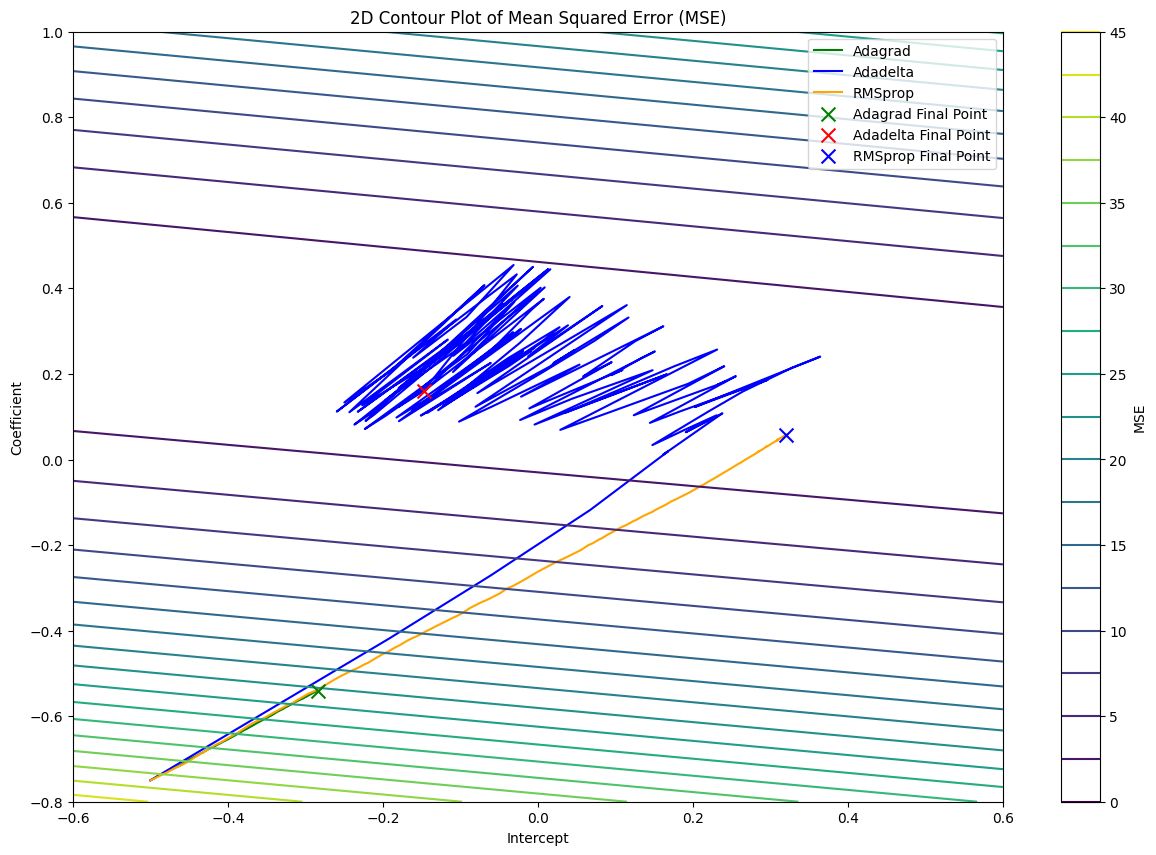

In [18]:
intercept_range = np.linspace(-0.6, 0.6, 150)
coefficient_range = np.linspace(-0.8, 1.0, 150)
intercept_grid, coefficient_grid = np.meshgrid(intercept_range, coefficient_range)

mse_grid = np.zeros_like(intercept_grid)

for i in range(len(intercept_range)):
    for j in range(len(coefficient_range)):
        # Get current intercept and coefficient values
        intercept = intercept_grid[i, j]
        coefficient = coefficient_grid[i, j]
        
        # Calculate predicted values using the current intercept and coefficient
        y_pred = intercept + coefficient * sepal_length.squeeze()
        
        # Calculate MSE (Mean Squared Error)
        mse = np.mean((y_pred - petal_width)**2)
        
        # Store MSE in the corresponding grid position
        mse_grid[i, j] = mse

plt.figure(figsize=(15, 10))
contour = plt.contour(intercept_grid, coefficient_grid, mse_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='MSE')
plt.plot(adagrad_df['intercept'], adagrad_df['coefficient'], color='green', zorder=1, label="Adagrad")
plt.plot(adadelta_df['intercept'], adadelta_df['coefficient'], color='blue', zorder=1, label="Adadelta")
plt.plot(rmsprop_df['intercept'], rmsprop_df['coefficient'], color='orange', zorder=1, label="RMSprop")
plt.xlabel('Intercept')
plt.ylabel('Coefficient')
plt.title('2D Contour Plot of Mean Squared Error (MSE)')
plt.scatter(adagrad_df.loc[len(adagrad_df)-1, 'intercept'], adagrad_df.loc[len(adagrad_df)-1, 'coefficient'], color='green', marker='x', s=100, zorder=2, label='Adagrad Final Point')
plt.scatter(adadelta_df.loc[len(adadelta_df)-1, 'intercept'], adadelta_df.loc[len(adadelta_df)-1, 'coefficient'], color='red', marker='x', s=100, zorder=2, label='Adadelta Final Point')
plt.scatter(rmsprop_df.loc[len(rmsprop_df)-1, 'intercept'], rmsprop_df.loc[len(rmsprop_df)-1, 'coefficient'], color='blue', marker='x', s=100, zorder=2, label='RMSprop Final Point')
plt.legend()
plt.show()

In [16]:
# save the plot


<Figure size 640x480 with 0 Axes>